In [1]:
import plot
from shap.maskers import Independent
from sklearn.utils import resample, shuffle
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
shap.initjs()

In [2]:
with open('classifiers.pickle', 'rb') as f:
    clf_a, clf_b = pickle.load(f)
with open('predictions.pickle', 'rb') as f:
    X, display_data, feature_names, n_features, n_samples, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)

In [3]:
try:
    with open(f'shapvalues.soa.log_odds.pickle', 'rb') as f:
        shap_values_a, shap_values_b, shap_values_a_vs_b, is_finite, is_outlier, is_normal, feature_order = pickle.load(f)
        print('Loaded cached shap values')
except FileNotFoundError:
    print('No cached shap values found')

Loaded cached shap values


## Generate Explanations

Now we define the functions to be explained:

In [4]:
proba_to_log_proba = lambda proba: np.log(proba)
log_proba_to_log_odds = lambda log_proba: log_proba[:, 1] - log_proba[:, 0]
predict_log_odds_a = lambda X: log_proba_to_log_odds(clf_a.predict_log_proba(X))
predict_log_odds_b = lambda X: log_proba_to_log_odds(proba_to_log_proba(clf_b.predict_proba(X)))

And now we calculate SHAP values for each function:

In [5]:
%%time

background_data = X
def explain(predict):
    masker = Independent(data=background_data, max_samples=100)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X)
    shap_values.display_data = display_data
    return shap_values

shap_values_a = explain(predict_log_odds_a)
shap_values_b = explain(predict_log_odds_b)

shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data
shap_values_a_vs_b.display_data = shap_values_a.display_data

is_finite = np.all(np.isfinite(shap_values_a.values), axis=1) & np.all(np.isfinite(shap_values_b.values), axis=1)
is_outlier = np.any(shap_values_a.abs.values > 8, axis=1) | np.any(shap_values_b.abs.values > 8, axis=1)
is_normal = is_finite & ~is_outlier
feature_order = np.flip(shap_values_a_vs_b[is_normal].abs.mean(axis=0).values.argsort())

with open(f'shapvalues.soa.log_odds.pickle', 'wb') as f:
    pickle.dump((shap_values_a, shap_values_b, shap_values_a_vs_b, is_finite, is_outlier, is_normal, feature_order), f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 32562it [24:50, 21.79it/s]                           
Permutation explainer: 32562it [25:27, 21.19it/s]                           


CPU times: user 1h 11min 42s, sys: 8min 19s, total: 1h 20min 1s
Wall time: 50min 26s


## Analyze

In [7]:
print(f'non-finite SHAP-values: {np.sum(~is_finite)}')
print(f'outlier SHAP-values: {np.sum(is_outlier)}')
print(f'total SHAP-values: {len(is_normal)}')

non-finite SHAP-values: 0
outlier SHAP-values: 200
total SHAP-values: 32561


### Feature Importance

We estimate it with the mean absolute SHAP value (which is the default for this plot) and will also sort features subsequently in this order

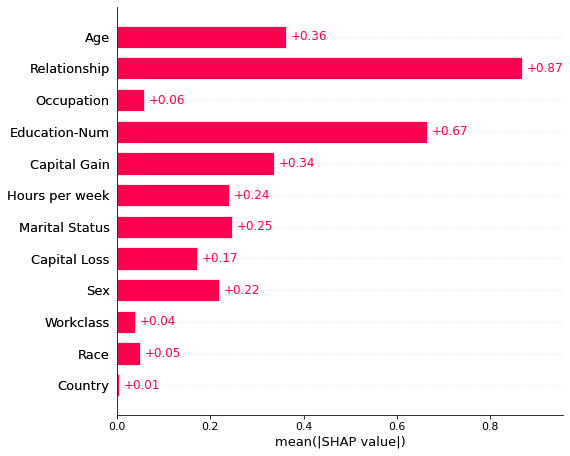

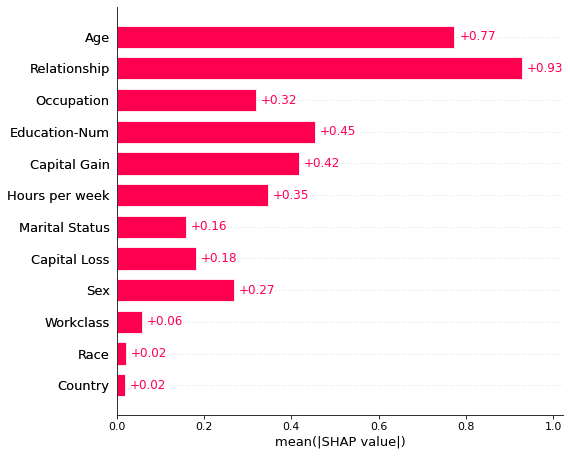

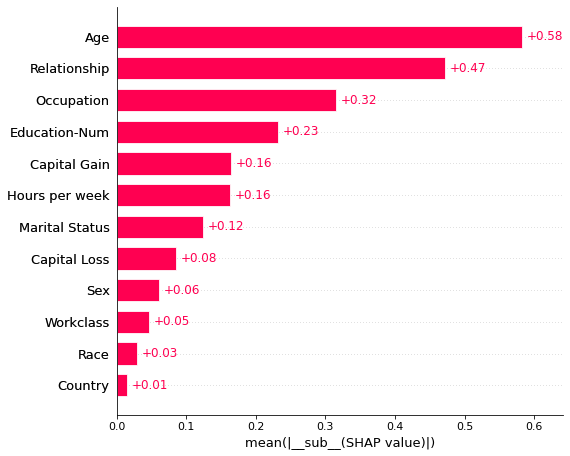

In [8]:
shap.plots.bar(shap_values_a[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_b[is_normal], order=feature_order, max_display=n_features)
shap.plots.bar(shap_values_a_vs_b[is_normal], order=feature_order, max_display=n_features)

### SHAP Value Distribution

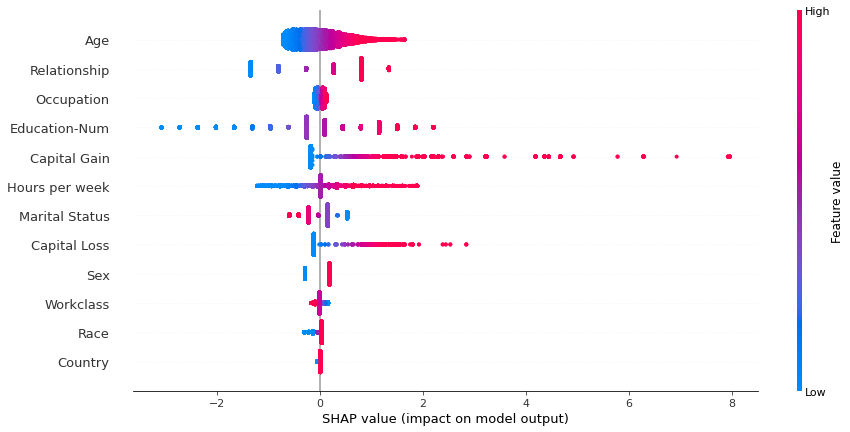

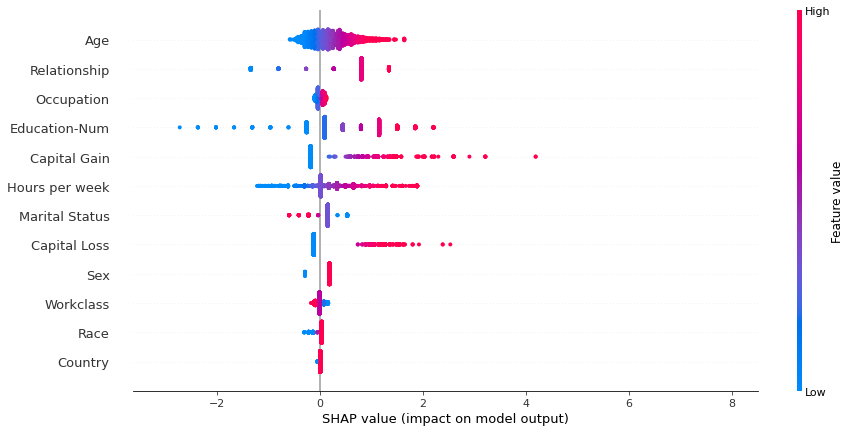

In [9]:
shap.plots.beeswarm(shap_values_a[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_a[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

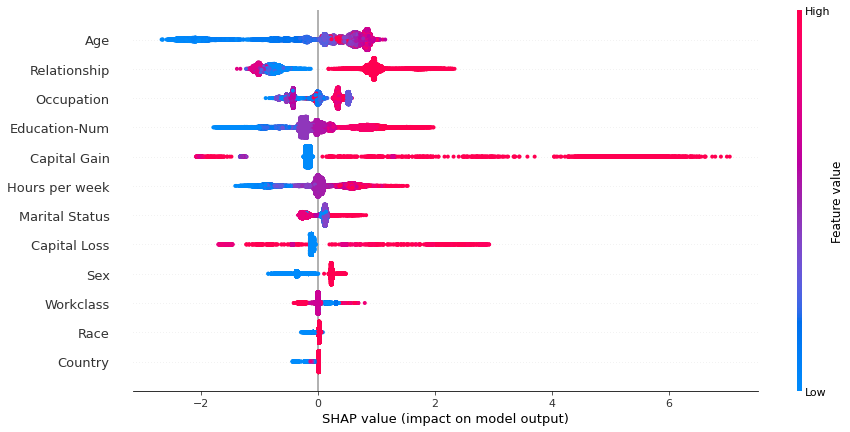

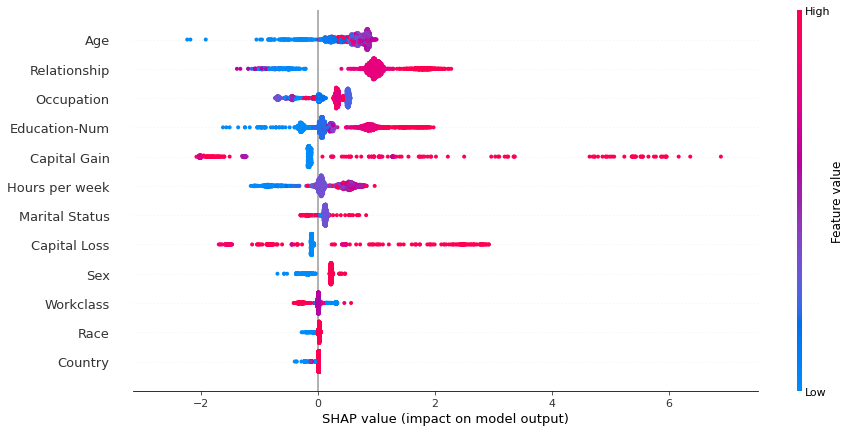

In [10]:
shap.plots.beeswarm(shap_values_b[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_b[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

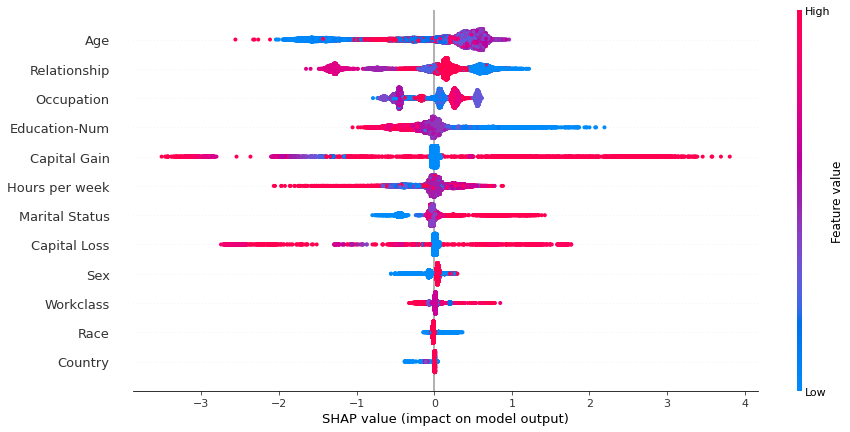

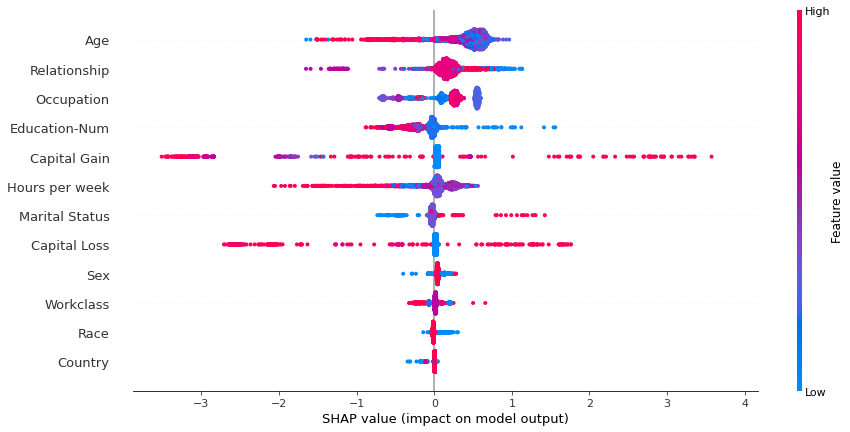

In [11]:
shap.plots.beeswarm(shap_values_a_vs_b[is_normal], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
xlim = plt.xlim()
plt.show()
shap.plots.beeswarm(shap_values_a_vs_b[is_normal & (pred_a != pred_b)], order=feature_order, max_display=n_features, plot_size=(14, 7), show=False)
plt.xlim(xlim)
plt.show()

### Features' Partial Dependence Plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


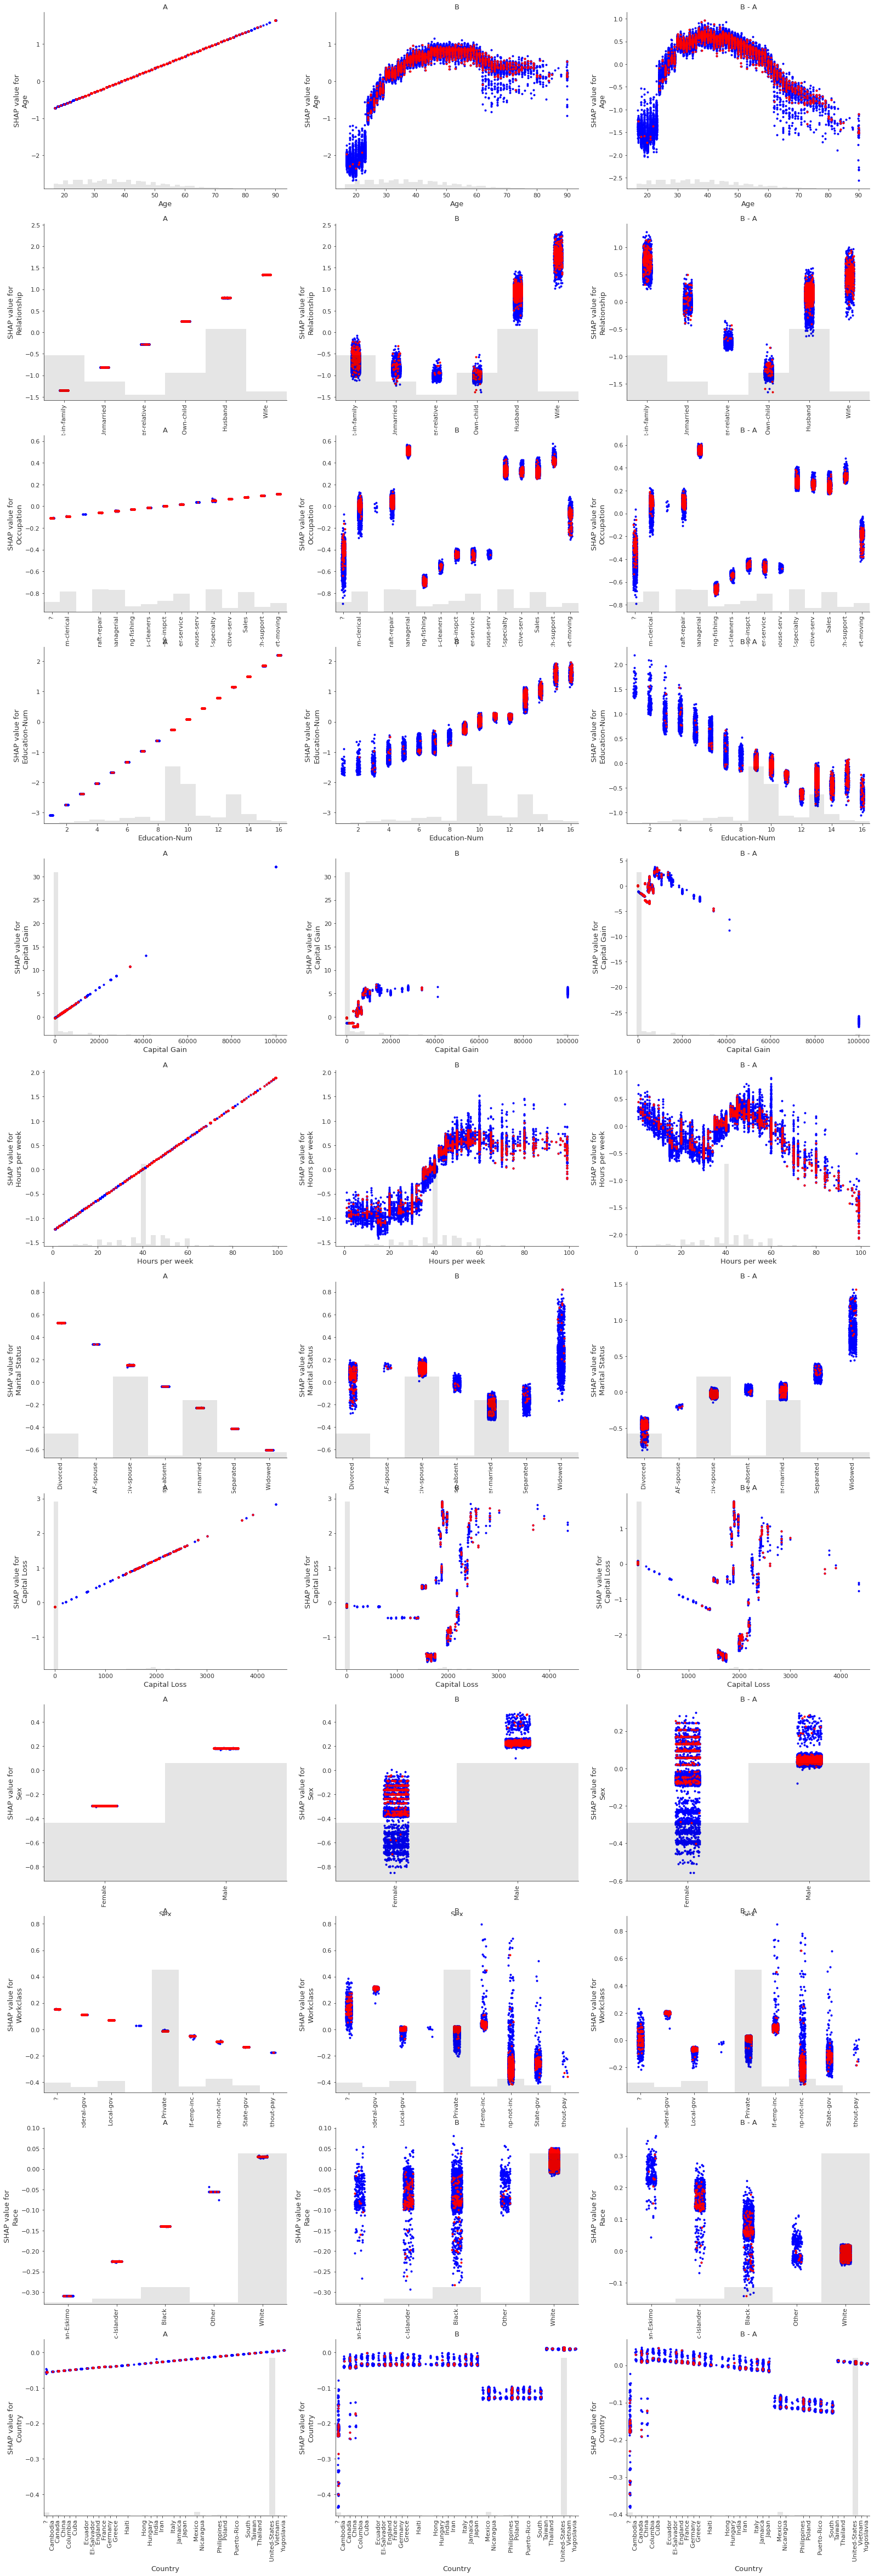

In [12]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
i = 1
for feature in feature_names[feature_order]:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2, sharey=None)
    shap.plots.scatter(shap_values_a[:, feature], title='A', ax=ax1, color='blue', show=False)
    shap.plots.scatter(shap_values_a[pred_a != pred_b, feature], title='A', ax=ax1, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_b[:, feature], title='B', ax=ax2, color='blue', show=False)
    shap.plots.scatter(shap_values_b[pred_a != pred_b, feature], title='B', ax=ax2, color='red', hist=False, show=False)
    shap.plots.scatter(shap_values_a_vs_b[:, feature], title='B - A', ax=ax3, color='blue', show=False)
    shap.plots.scatter(shap_values_a_vs_b[pred_a != pred_b, feature], title='B - A', ax=ax3, color='red', hist=False, show=False)
    i += n_columns
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

In [13]:
idx_diff = indices[is_normal & (pred_a != pred_b)]
idx_equal = indices[is_normal & (pred_a == pred_b)]
if len(idx_diff) > 500:
    idx_diff = shuffle(idx_diff, random_state=0, n_samples=500)
if len(idx_equal) > 500:
    idx_equal = shuffle(idx_equal, random_state=0, n_samples=500)

In [14]:
order = plot.shap_force(shap_values_a_vs_b[idx_diff], 'A vs. B')
plot.shap_force(shap_values_a[idx_diff], 'A', ordering=order)
plot.shap_force(shap_values_b[idx_diff], 'B', ordering=order);

In [15]:
order = plot.shap_force(shap_values_a_vs_b[idx_equal], 'A vs. B')
plot.shap_force(shap_values_a[idx_equal], 'A', ordering=order)
plot.shap_force(shap_values_b[idx_equal], 'B', ordering=order);

### Hierarchically Clustered SHAP Values

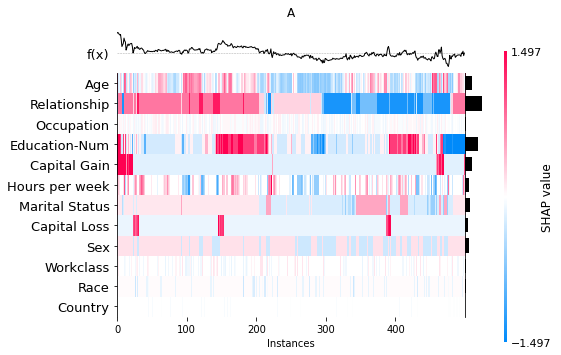

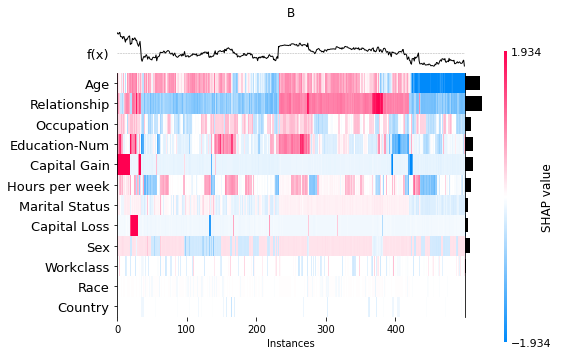

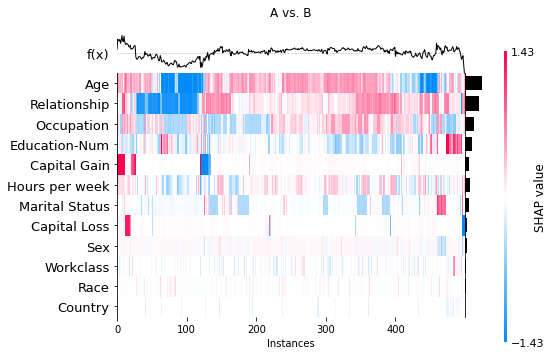

In [16]:
plot.shap_heatmap(shap_values_a[idx_equal], 'A', feature_order)
plot.shap_heatmap(shap_values_b[idx_equal], 'B', feature_order)
plot.shap_heatmap(shap_values_a_vs_b[idx_equal], 'A vs. B', feature_order)

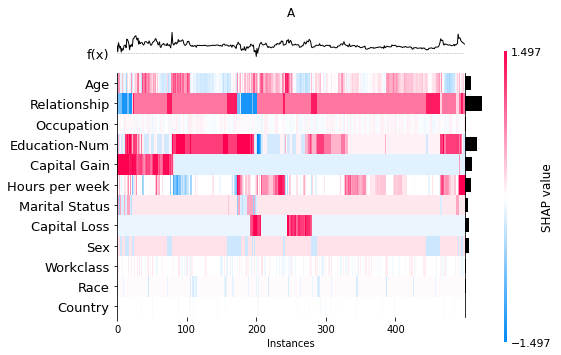

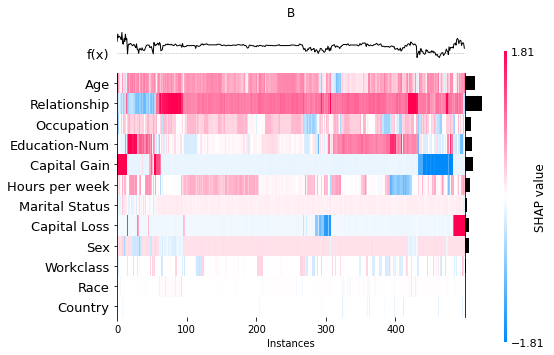

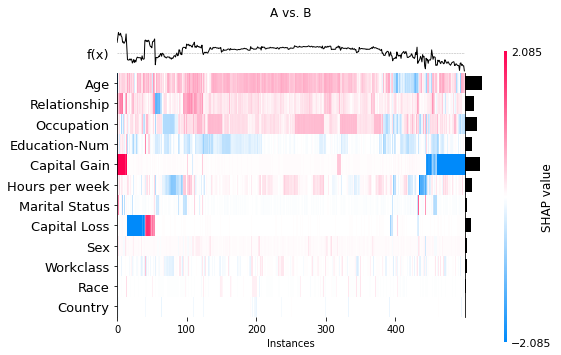

In [17]:
plot.shap_heatmap(shap_values_a[idx_diff], 'A', feature_order)
plot.shap_heatmap(shap_values_b[idx_diff], 'B', feature_order)
plot.shap_heatmap(shap_values_a_vs_b[idx_diff], 'A vs. B', feature_order)

### Unusual instances

#### Outliers in SHAP-values

An unusually high capital gain leads to a very big SHAP value for the instance's feature.

In [18]:
idx_outliers = np.where(is_outlier & is_finite)[0]

In [19]:
pd.DataFrame(display_data[idx_outliers, :], index=idx_outliers, columns=feature_names)

Age          Workclass Education-Num       Marital Status  \
106    17.0                  ?           6.0        Never-married   
1246   54.0       Self-emp-inc          15.0   Married-civ-spouse   
1368   52.0            Private           9.0   Married-civ-spouse   
1482   53.0       Self-emp-inc           9.0   Married-civ-spouse   
1528   52.0            Private          13.0   Married-civ-spouse   
...     ...                ...           ...                  ...   
31972  43.0       Self-emp-inc          15.0   Married-civ-spouse   
32090  66.0            Private          13.0   Married-civ-spouse   
32238  47.0            Private          15.0   Married-civ-spouse   
32370  53.0   Self-emp-not-inc          15.0        Never-married   
32518  57.0          Local-gov           9.0   Married-civ-spouse   

             Occupation    Relationship                 Race      Sex  \
106                   ?       Own-child                White   Female   
1246     Prof-specialty         Husband                White     Male   
1368    Exec-managerial         Husband   Asian-Pac-Islander     Male   
1482              Sales         Husband                White     Male   
1528    Exec-managerial         Husband                White     Male   
...                 ...             ...                  ...      ...   
31972   Exec-managerial         Husband                White     Male   
32090   Exec-managerial         Husband                White     Male   
32238   Exec-managerial         Husband                White     Male   
32370    Prof-specialty   Not-in-family   Asian-Pac-Islander     Male   
32518      Craft-repair         Husband                White     Male   

      Capital Gain Capital Loss Hours per week         Country  
106        34095.0          0.0           32.0   United-States  
1246       99999.0          0.0           60.0   United-States  
1368       99999.0          0.0           40.0           Japan  
1482       99999.0          0.0           40.0   United-States  
1528       99999.0          0.0           50.0   United-States  
...            ...          ...            ...             ...  
31972      99999.0          0.0           40.0   United-States  
32090      99999.0          0.0           55.0               ?  
32238      99999.0          0.0           40.0   United-States  
32370      27828.0          0.0           40.0     Philippines  
32518      99999.0          0.0           40.0   United-States  

[200 rows x 12 columns]

In [20]:
for idx in shuffle(idx_outliers, n_samples=3):
    plot.shap_force(shap_values_a[idx], f'A (#{idx})')
    plot.shap_force(shap_values_b[idx], f'B (#{idx})')

#### Non-finite SHAP-values

In [21]:
idx_nonfinite = np.where(~is_finite)[0]

In [22]:
pd.DataFrame(display_data[idx_nonfinite, :], index=idx_nonfinite, columns=feature_names)

Empty DataFrame
Columns: [Age, Workclass, Education-Num, Marital Status, Occupation, Relationship, Race, Sex, Capital Gain, Capital Loss, Hours per week, Country]
Index: []

In [23]:
pd.DataFrame(shap_values_a[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)

ValueError: Empty data passed with indices specified.

In [ ]:
pd.DataFrame(shap_values_b[idx_nonfinite].values, index=idx_nonfinite, columns=feature_names)